In [1]:
import os
%pwd

'/home/petar/Documents/python_projects/petar-milivojevic-mlhU-machine-learning-new-mP1l/research'

In [2]:
os.chdir('../')
%pwd

'/home/petar/Documents/python_projects/petar-milivojevic-mlhU-machine-learning-new-mP1l'

In [4]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelEvaluationConfig:
    root_dir: Path
    test_data: Path
    models: Path
    eval_stats: Path
    model_params: dict

In [5]:
from aiusage.constant import *
from aiusage.utils.main_utils import create_directories, read_yaml

class ConfigurationManager:
    def __init__(
        self,
        config_file_path = CONFIG_FILE_PATH,
        params_file_path = PARAMS_FILE_PATH,
        schema_file_path = SCHEMA_FILE_PATH
    ):
        self.config = read_yaml(config_file_path)
        self.params = read_yaml(params_file_path)
        self.schema = read_yaml(schema_file_path)
        
        create_directories([self.config.artifacts_root])
    
    def get_model_evaluation_config(self) -> ModelEvaluationConfig:
        config = self.config.model_evaluation
        params = self.params
        
        create_directories([config.eval_stats])
        
        model_evaluation_config = ModelEvaluationConfig(
            root_dir=config.root_dir,
            test_data=config.test_data,
            models=config.models,
            eval_stats=config.eval_stats,
            model_params=params
        )
        
        return model_evaluation_config

In [11]:
from aiusage.constant.costum_dataset import AICodeDataset
from aiusage.constant.costum_model import CustomBERTModel
from aiusage.utils.main_utils import save_json, plot_confusion_matrix, plot_roc_curve
from torch.utils.data import DataLoader
import torch
from torch import nn
from transformers import BertTokenizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tqdm.notebook import tqdm
import pandas as pd

class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config
    
    def model_testing(self):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print('Device: ', device)

        test_df = pd.read_csv(self.config.test_data)
        test_list = list(test_df[test_df.columns[0]])
        test_labels_list = list(test_df[test_df.columns[1]])

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        test_dataset = AICodeDataset(test_list, test_labels_list, tokenizer)
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.config.model_params.batch_size,
            shuffle=False
        )
        
        criterion = nn.BCEWithLogitsLoss()

        for fold in tqdm(range(self.config.model_params.num_folds)):
            model = CustomBERTModel(dropout_prob=self.config.model_params.dropout).to(device)
            model.load_state_dict(torch.load(os.path.join(self.config.models, f'model_{fold}.pth')))
            model.eval()

            total_loss = 0
            test_preds = []
            test_labels = []

            with torch.no_grad():
                for batch in tqdm(test_loader):
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].unsqueeze(1).to(device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()

                    preds = torch.sigmoid(outputs).cpu().detach().numpy().flatten()
                    test_preds.extend(preds)
                    test_labels.extend(labels.cpu().numpy().flatten())
            
            binary_test_preds = [
                1 if pred >= self.config.model_params.threshold else 0 for pred in test_preds
            ]

            binary_test_labels = [
                1 if label >= self.config.model_params.threshold else 0 for label in test_labels
            ]

            report = classification_report(
                binary_test_labels,
                binary_test_preds,
                zero_division=0,
                output_dict=True
            )

            save_json(
                os.path.join(self.config.eval_stats, f'report_{fold}_{self.config.model_params.threshold}'), 
                report
            )

            conf_matrix = confusion_matrix(binary_test_labels, binary_test_preds)

            plot_confusion_matrix(
                conf_matrix,
                self.config.eval_stats,
                fold,
                f'Confusion Matrix for Fold {fold} and Threshold {self.config.model_params.threshold}',
                self.config.model_params.threshold
            )

            auc_score = roc_auc_score(binary_test_labels, test_preds)
            auc_score_dict = {'auc_score': auc_score}

            save_json(
                os.path.join(self.config.eval_stats, f'auc_score_{fold}_{self.config.model_params.threshold}'), 
                auc_score_dict
            )

            plot_roc_curve(
                binary_test_labels,
                binary_test_preds,
                self.config.eval_stats,
                fold,
                self.config.model_params.threshold
            )

[2025-01-08 09:32:29,790: INFO: main_utils: created directory at: artifacts]
[2025-01-08 09:32:29,791: INFO: main_utils: created directory at: artifacts/model_evaluation/eval_stats]
Device:  cuda


  0%|          | 0/5 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_14271/1479516683.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We 

  0%|          | 0/4 [00:00<?, ?it/s]

[2025-01-08 09:32:32,317: INFO: main_utils: json file saved at: artifacts/model_evaluation/eval_stats/report_0_0.5]
[2025-01-08 09:32:32,395: INFO: main_utils: json file saved at: artifacts/model_evaluation/eval_stats/auc_score_0_0.5]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_14271/1479516683.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We 

FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/model_trainer/models/model_1.pth'

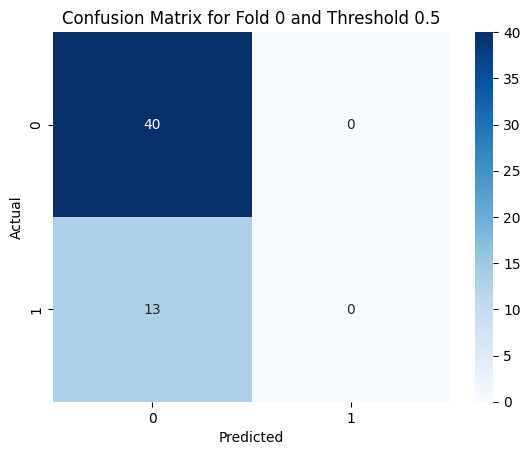

In [10]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation = ModelEvaluation(config=model_evaluation_config)
    model_evaluation.model_testing()

except Exception as e:
    raise e